Let's take two time series—one stationary and one non-stationary—and fit both to models from the MA (Moving Average) class.

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

First, let's take the non-stationary series.

In [ ]:
robberies_in_boston = pd.read_csv("monthly-boston-armed-robberies-j.csv")

In [ ]:
robberies_in_boston = robberies_in_boston.iloc[:,1]

In [ ]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [ ]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


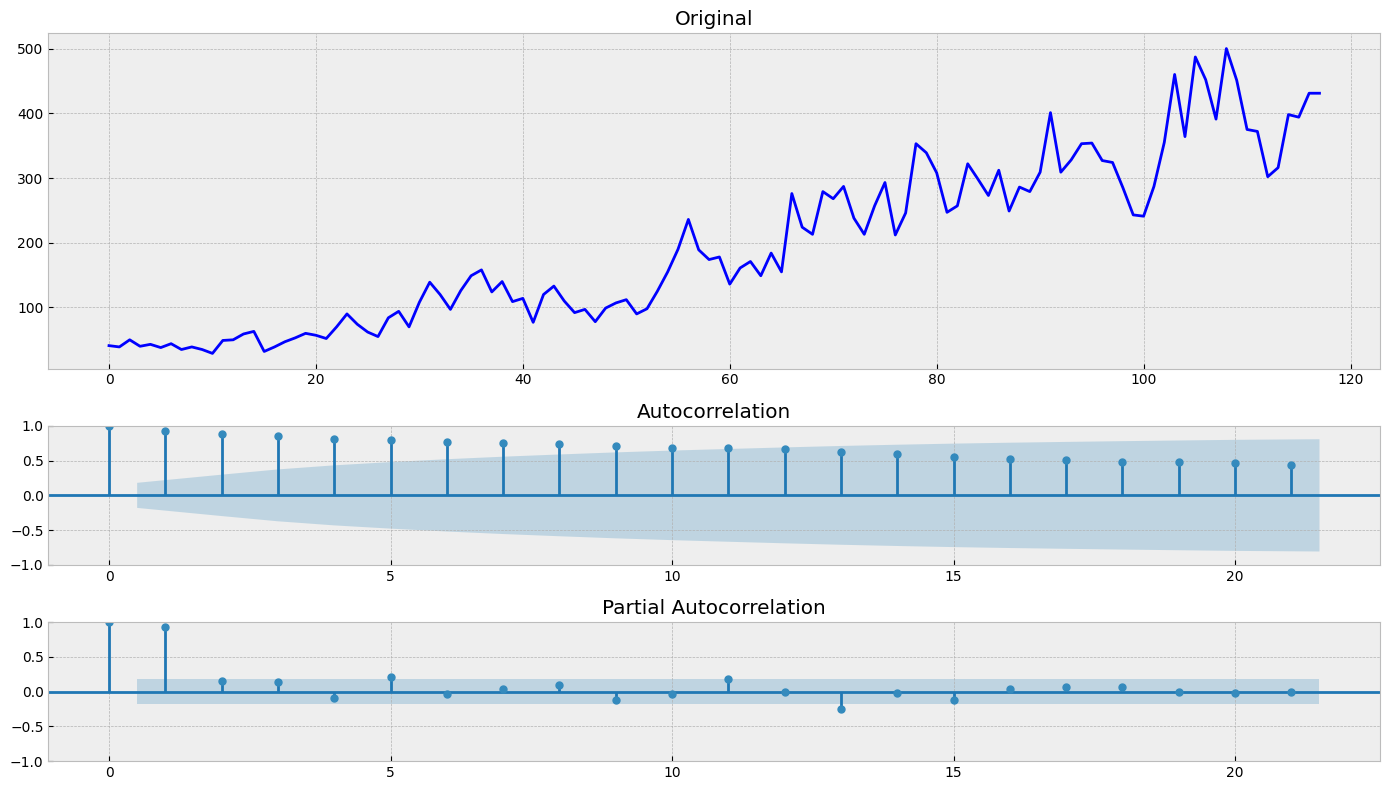

In [ ]:
tsplot(robberies_in_boston)

In [ ]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [ ]:
ser = moving_average(robberies_in_boston, 7)

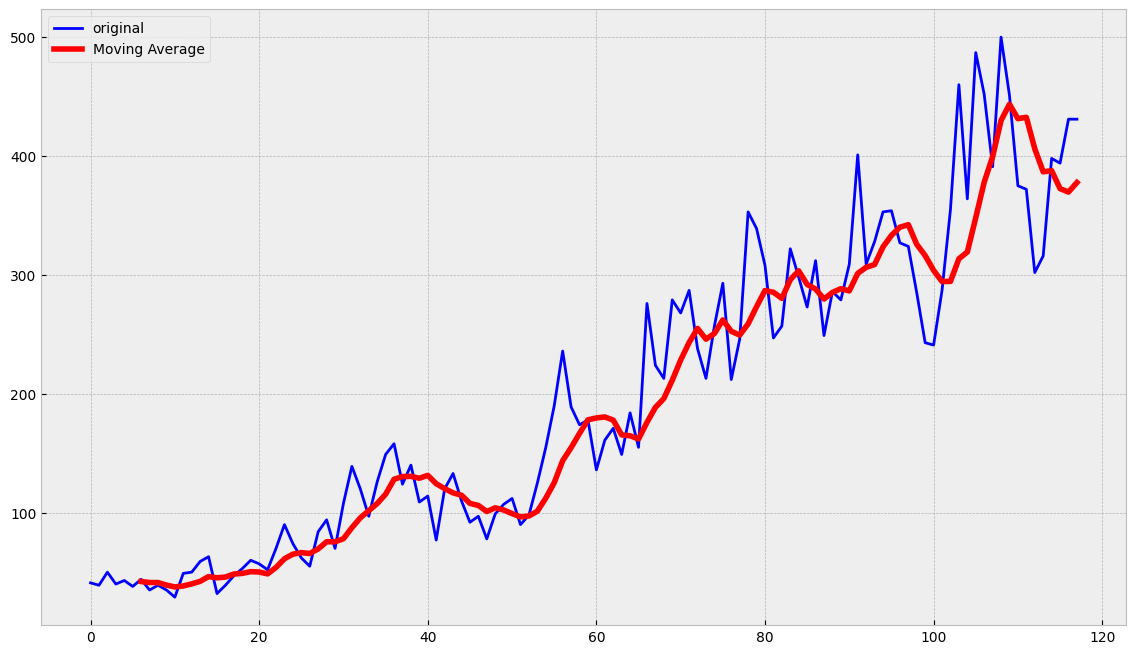

In [ ]:
ser = moving_average(robberies_in_boston, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(robberies_in_boston, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

The MA model lags and does not fit the series very closely, often deviating significantly from it, as expected.

In [ ]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

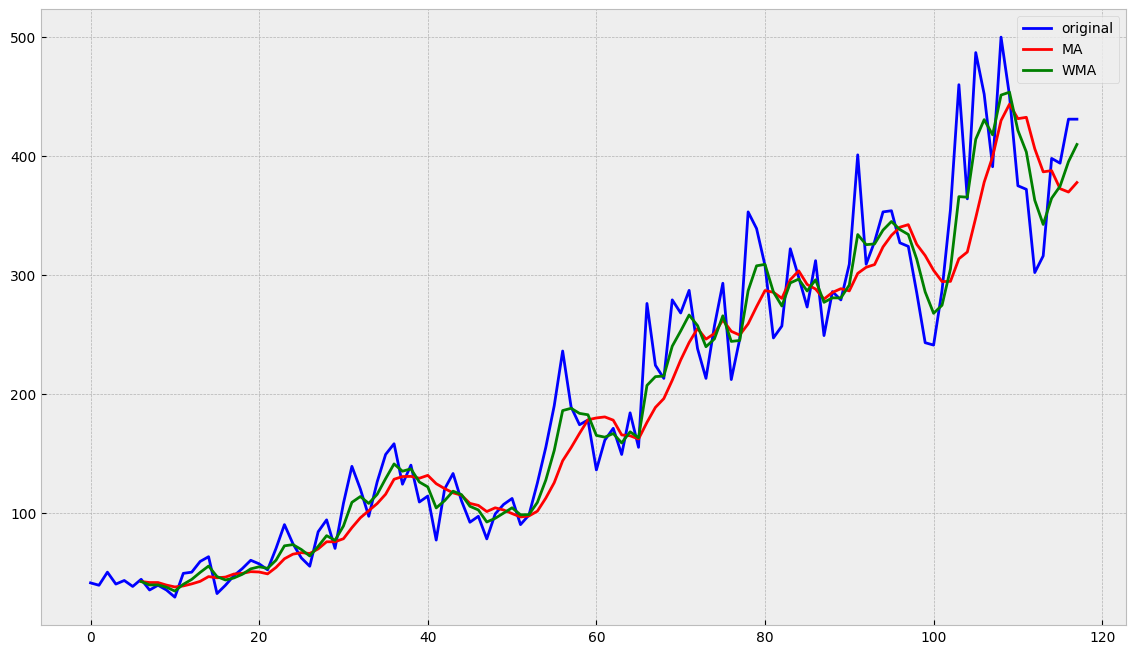

In [ ]:
wma = weighted_moving_average(robberies_in_boston, 7, [1,1,2,3,5,8,13])
ma = moving_average(robberies_in_boston, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(robberies_in_boston, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

The WMA model fits the time series better.

In [ ]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

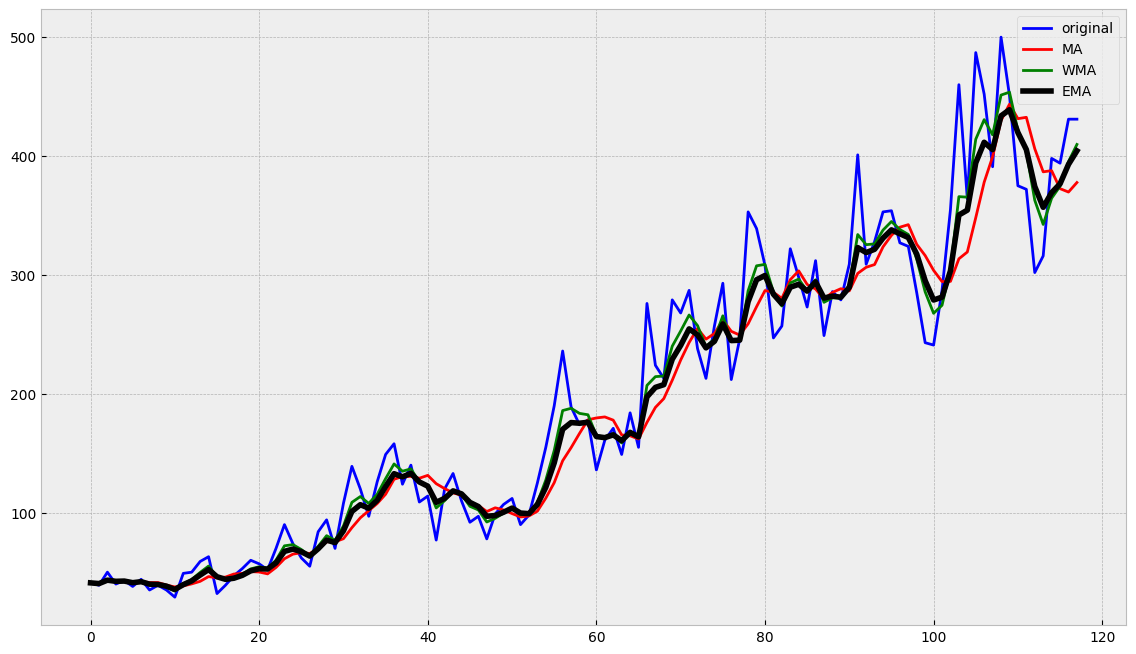

In [ ]:
ema = exponential_moving_average(robberies_in_boston, 0.3)
wma = weighted_moving_average(robberies_in_boston, 7, [1,1,2,3,5,8,13])
ma = moving_average(robberies_in_boston, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(robberies_in_boston, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

The EMA model does not fit the time series as closely.

In [ ]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [ ]:
def plot_dema(alpha, beta):
    dema = double_ema(robberies_in_boston, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(robberies_in_boston, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

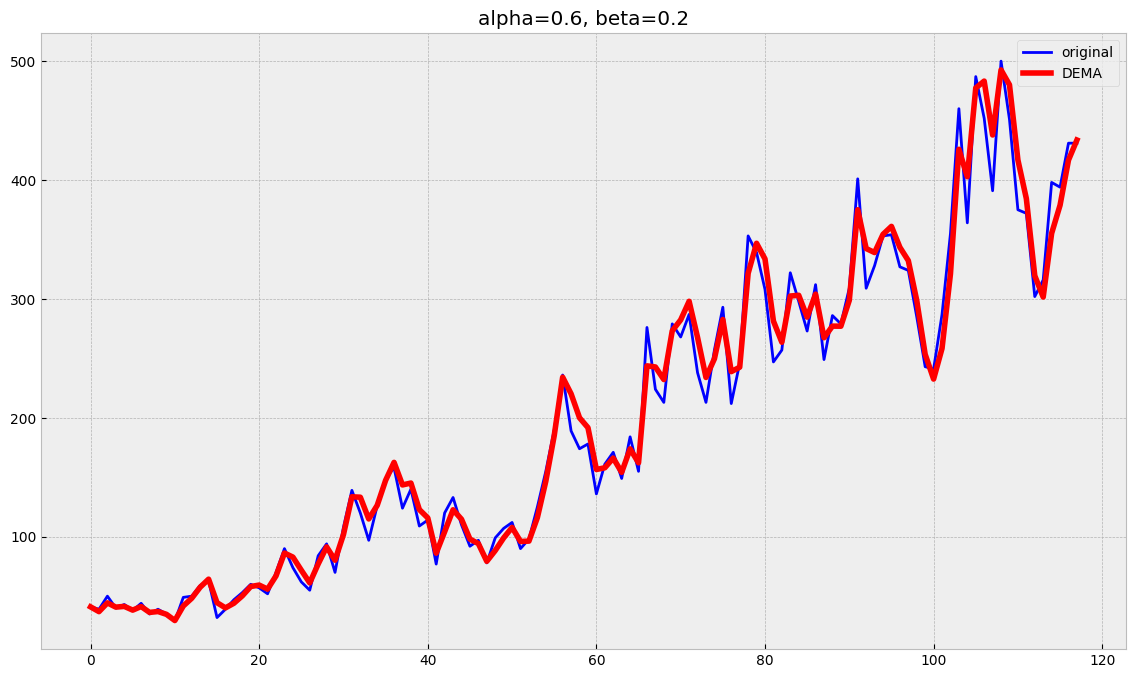

In [ ]:
plot_dema(0.6, 0.2)

DEMA with parameters 0.6 and 0.2 shows a very good result. Since there is no seasonality in the series, the Holt-Winters method is not needed.

Now let's apply MA methods to the stationary time series.

In [ ]:
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

In [ ]:
female_births = female_births.iloc[:,1]

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


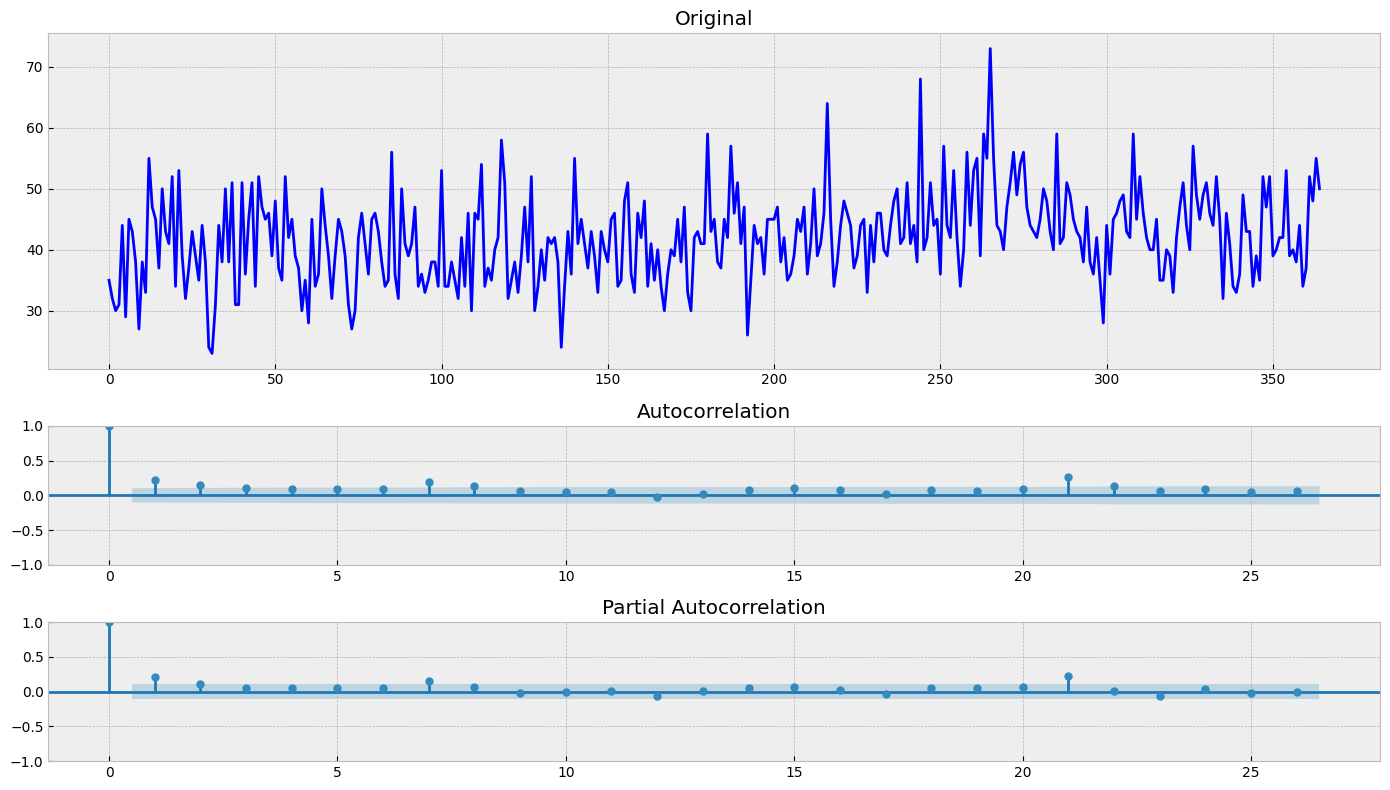

In [ ]:
tsplot(female_births)

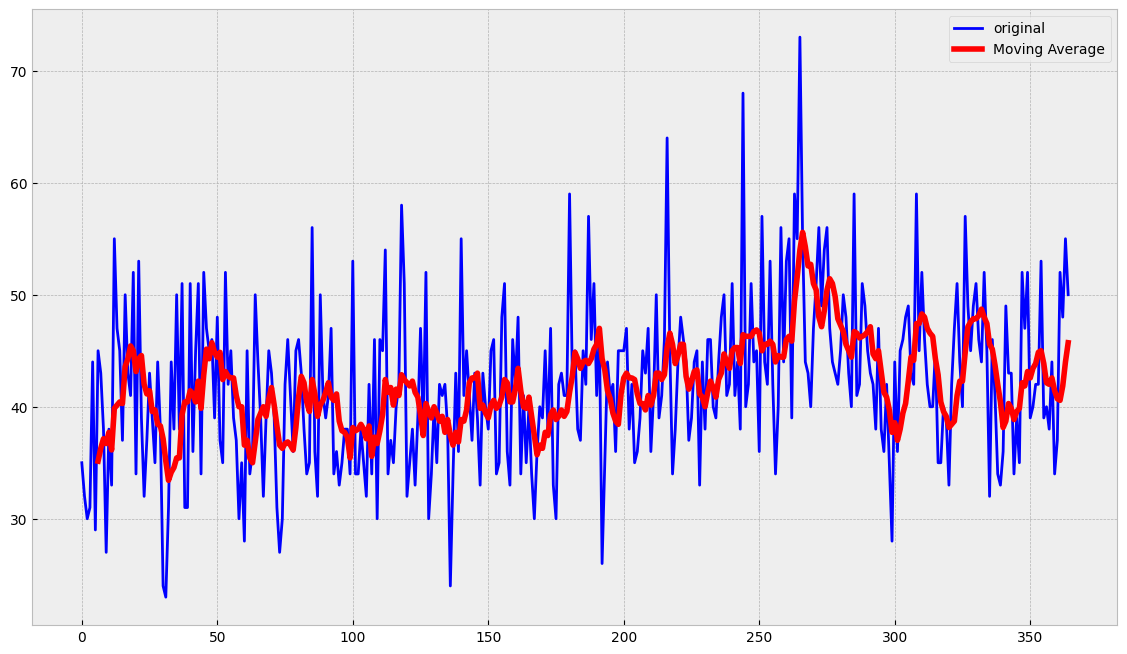

In [ ]:
ser = moving_average(female_births, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

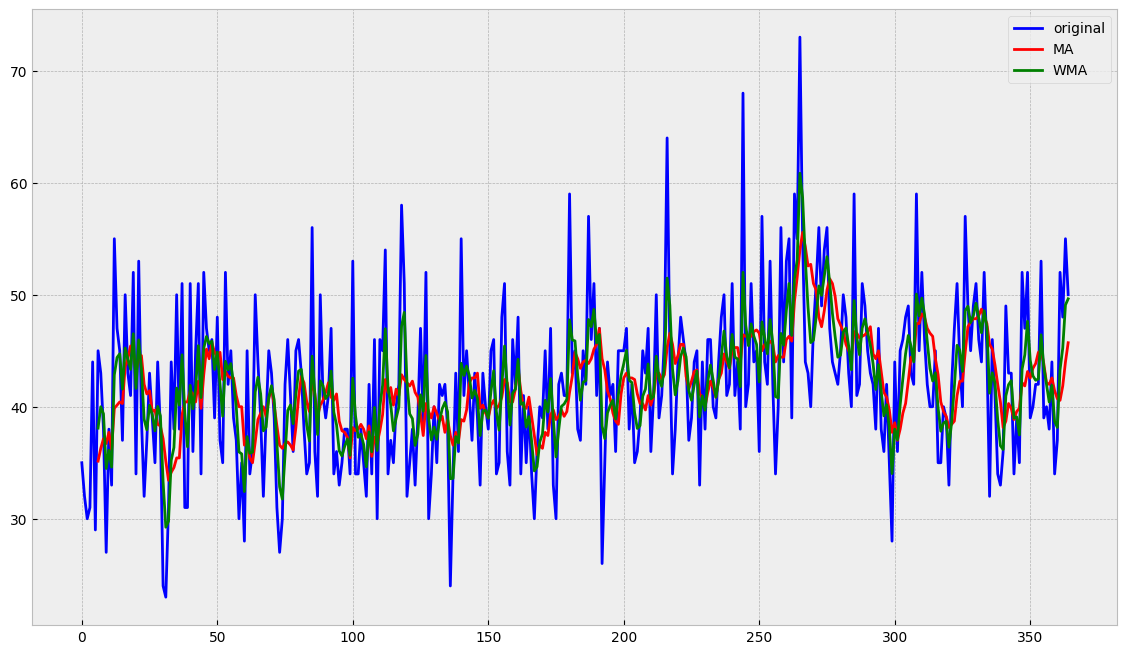

In [ ]:
wma = weighted_moving_average(female_births, 7, [1,1,2,3,5,8,13])
ma = moving_average(female_births, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

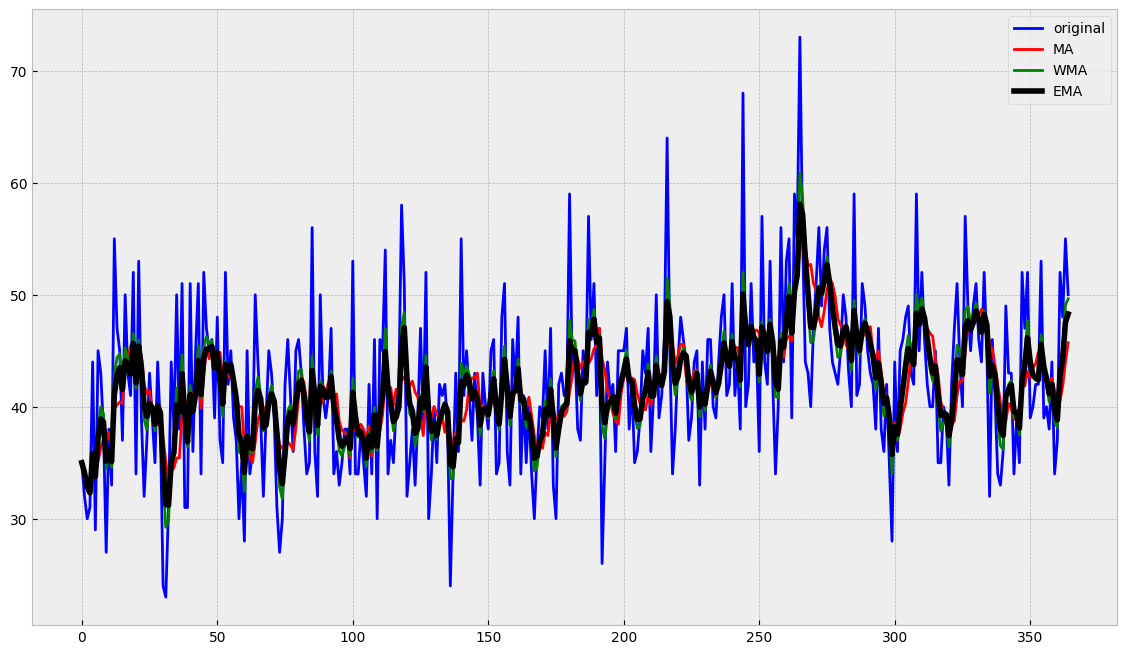

In [ ]:
ema = exponential_moving_average(female_births, 0.3)
wma = weighted_moving_average(female_births, 7, [1,1,2,3,5,8,13])
ma = moving_average(female_births, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

In [ ]:
def plot_dema(alpha, beta):
    dema = double_ema(female_births, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(female_births, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

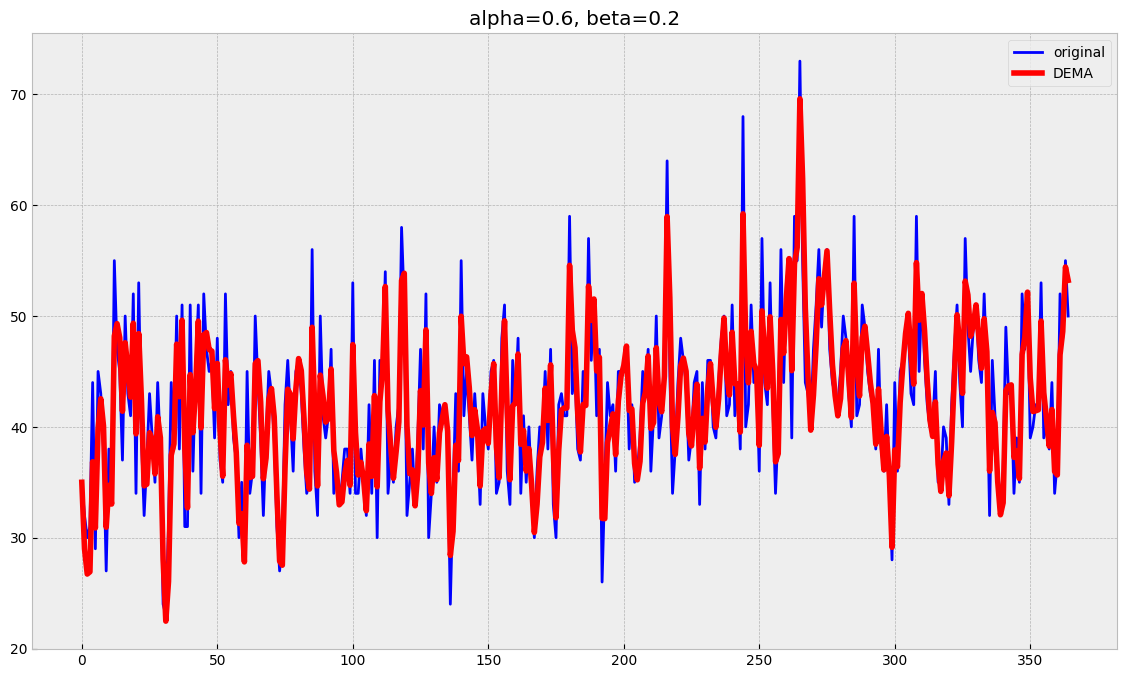

In [ ]:
plot_dema(0.6, 0.2)

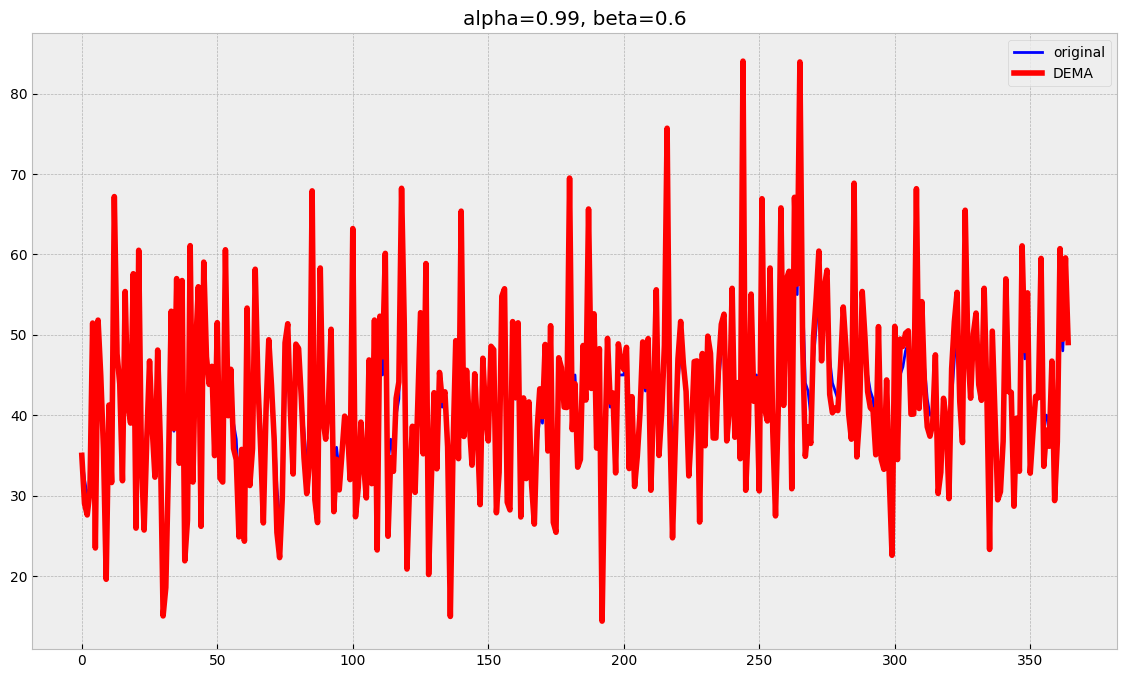

In [ ]:
plot_dema(0.99, 0.6)

As with the non-stationary time series, DEMA works the best.